Представьте, что вы работаете в государственной компании, предоставляющей анализ экономической ситуации в мире по заказу государства.

Перед вами стоит задача проанализировать ВВП африканской страны Гана. Для этого вам предоставили показатели ВВП Ганы за 62 года. Вам предстоит исследовать временной ряд, изучить его свойства, построить модели и сделать выводы по результатам.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt

from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from arch import arch_model
from sklearn.model_selection import train_test_split
from sklearn import linear_model

# Часть 1

## 1
Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.

In [3]:
data = pd.read_csv("ghana_gdp.csv", parse_dates=["year"], index_col=["year"])
data.rename(columns = {'GDP (current US$)':'GDP'}, inplace=True)
data.head()

,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 1960-01-01 to 2021-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GDP     62 non-null     float64
dtypes: float64(1)
memory usage: 992.0 bytes


<AxesSubplot:xlabel='year'>

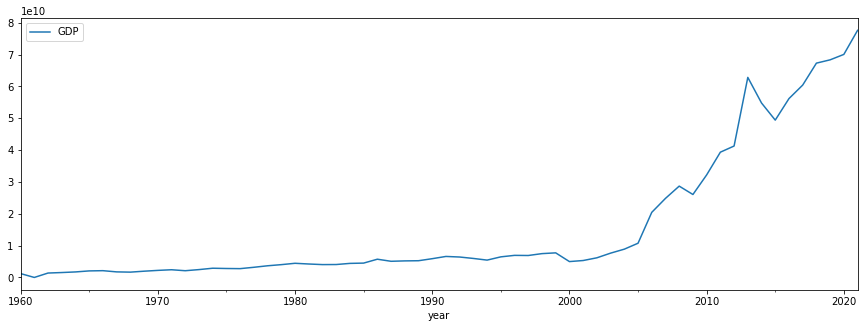

In [5]:
#plt.rcParams["figure.figsize"] = 10, 5
data.plot(figsize=(15, 5))

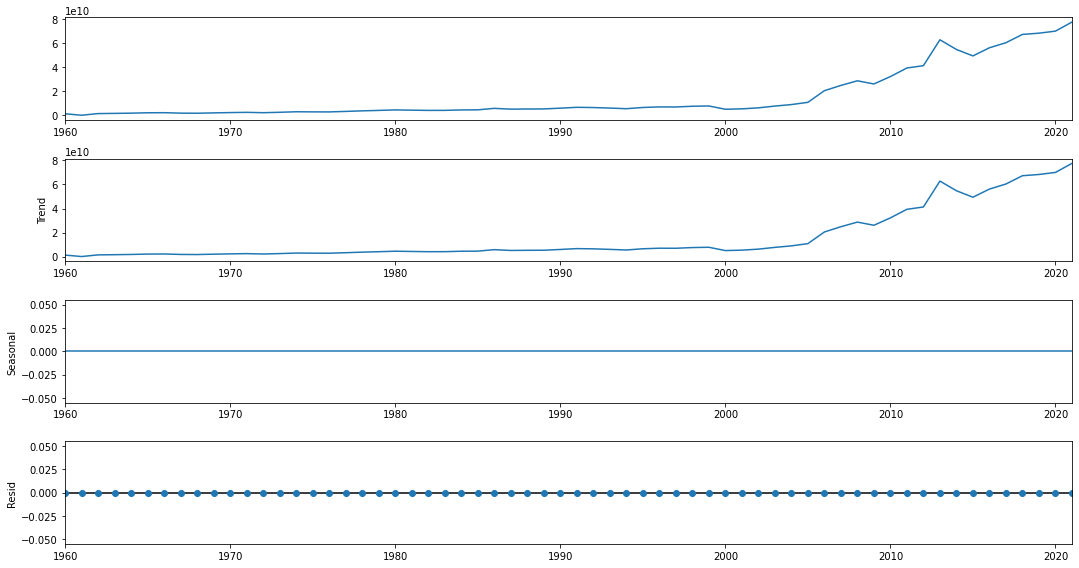

In [6]:
#производим декомпозицию временного ряда 
plt.rcParams["figure.figsize"] = 15, 8
decomposition = seasonal_decompose(data)
fig = decomposition.plot()
plt.show();

На графиках выше виден тренд на увеличение ВВП Ганы. Сезонность не выделенна, как и шум - они в районе 0.

Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

In [7]:
train_data = data.iloc[:-3]
test_data = data.iloc[-3:]
train_data.shape, test_data.shape

((59, 1), (3, 1))

## 2
Постройте график скользящего среднего, проанализируйте результат. 

In [9]:
# fig, axs = plt.subplots(nrows= 3 , ncols= 1 , figsize=(15, 8))

# #fig.suptitle('График скользящего среднего')

# #add data to plots
# axs[0].plot(train_data.GDP)
# axs[0].set_title('Исходный временной ряд')
# axs[1].plot(train_data.GDP.rolling(window=2).mean(), color="orange")
# axs[1].set_title('Скользящее среднее с окном 2')
# axs[1].legend(['window=2'])
# axs[2].plot(train_data.GDP.rolling(window=6).mean(), color="green")
# axs[2].set_title('Скользящее среднее с окном 6');
# axs[2].legend(['window=6']);
# #plt.plot(train_data.GDP.rolling(window=6).mean())

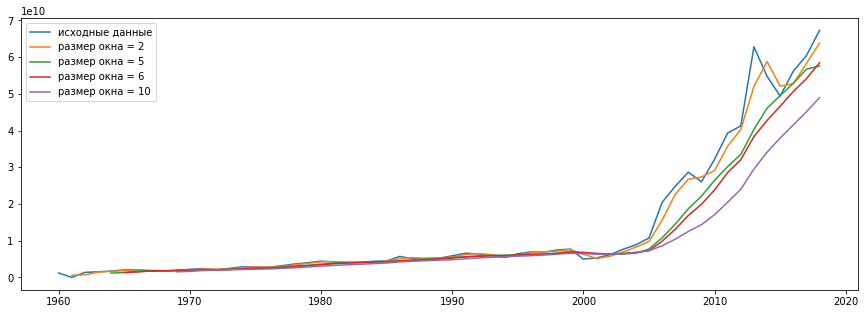

In [8]:
plt.rcParams["figure.figsize"] = 15, 5
plt.plot(train_data.GDP)
plt.plot(train_data.GDP.rolling(window=2).mean())
plt.plot(train_data.GDP.rolling(window=5).mean())
plt.plot(train_data.GDP.rolling(window=6).mean())
plt.plot(train_data.GDP.rolling(window=10).mean())
plt.legend(['исходные данные', 'размер окна = 2', 'размер окна = 5', 'размер окна = 6', 'размер окна = 10'])
plt.show();

Скользящее среднее помогло нам выделить тренд. Он явно читается как при окне равном 2, так и при окне равном 10. Из подобранных параметров окна наиболее оптимальным кажется window = 6. Сглаживает график лучше, чем при window = 5 и не так уводит тренд вниз как при window = 10.  Из графиков видим слабое увеличение ВВП с 1960 по 2005 года, и резкое увеличение ВВП с 2005 по 2021 года. 

## 3 
С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.

In [9]:
# adfuller(train_data)

def stat_test(df):
    test = adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['10%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

stat_test(train_data)

adf:  0.6529066974885364
p-value:  0.9888496277665572
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
есть единичные корни, ряд не стационарен


После теста Дики-Фуллера на стационарность ряда видим, что наша статистика (0.653) больше всех критических значений разного уровня значимости. Это значит, что наш ряд не является стационарным, следовательно будем использовать модель ARIMA.

Теперь проведем дифференцирование ряда и еще раз проверим на стационарность, таким образом подберем параметр d для модели ARIMA.

## Важно
Разберем вот этот момент:
data_diff = data.diff().diff().diff().dropna()  
или  
data_diff = data.diff(3).dropna()

Ответ менторов:
аргумент в .diff() - количество периодов для сдвига при применении, а значит не равно количеству раз последовательного применения .diff() с периодом 1. Это не дифференцирование функции, а взятие разностей, работает не как при нахождении дифференциировании-производных (тут последовательно). Просто называются одинаково, из-за этого путаница в логике из-за ассоциативного ряда.

## Необходимо передавать порядок аргументом .diff(2), он возвращает разницу между значением и значением со сдвигом 2. А .diff().diff() вернет изменения в изменении.

In [10]:
diff_data = train_data.diff().dropna()
#adfuller(diff_data)

stat_test(diff_data)

adf:  -1.6702483038320854
p-value:  0.446502932971385
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
есть единичные корни, ряд не стационарен


- 1.67 больше всех критических значений {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}.
Значит ряд все еще нестационарен.

In [11]:
# проверем еще одно дифференцирование
diff2_data = train_data.diff().diff().dropna()
#adfuller(diff2_data)

stat_test(diff2_data)

# adf:  -3.5836708658260306
# p-value:  0.006080989753876942
# Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
# единичных корней нет, ряд стационарен

adf:  -2.6408690561284884
p-value:  0.08484116917837692
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
единичных корней нет, ряд стационарен


Теперь ряд стационарен.
Параметр d = 2.
Параметры q и p будем подбирать из графиков автокорреляции acf и частичной автокорреляции pacf.

c:\Users\toiri\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 864x576 with 0 Axes>

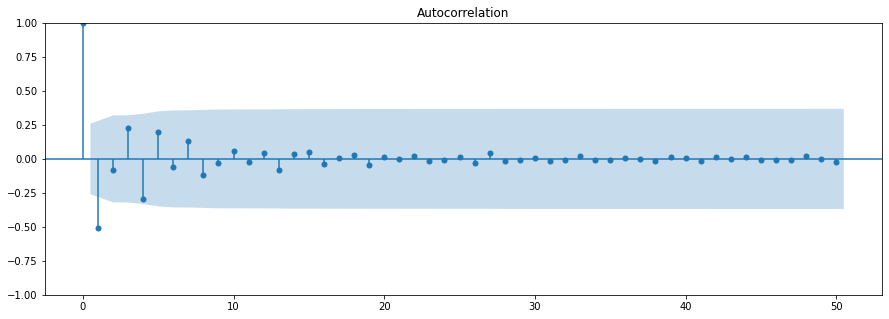

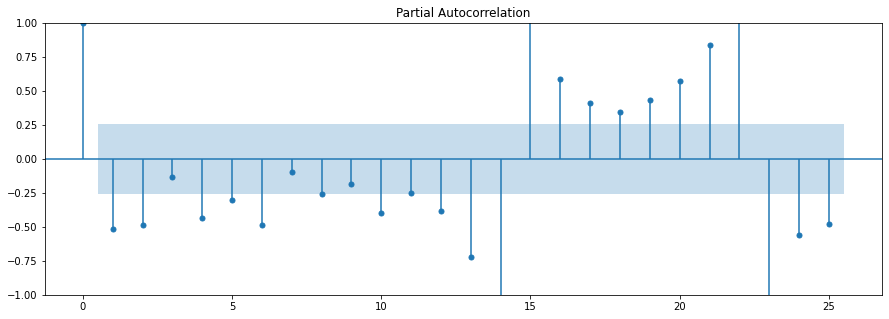

In [12]:
# построим графики автокорреляции acf и частичной автокорреляции pacf
plt.figure(figsize=(12,8))
sgt.plot_acf(diff2_data, lags=50)
sgt.plot_pacf(diff2_data, lags=25)
plt.show();

По полученным коррелограммам выбираем параметры. По ACF выбираем q = 1. По PACF возьмем p = 2, но можно посмотреть и при других значениях.

## ARIMA

In [13]:
# Построим модель ARIMA со следующими параметрами order = (p, d, q)

p = 2
d = 2
q = 1

arima_model = ARIMA(train_data, order=(2, 2, 1)) # ! порядок параметров order = (p, d, q)
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\toiri\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\toiri\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\toiri\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -1337.891
Date:                Mon, 05 Feb 2024   AIC                           2683.782
Time:                        20:18:38   BIC                           2691.954
Sample:                    01-01-1960   HQIC                          2686.958
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2525      0.230     -1.097      0.273      -0.704       0.199
ar.L2         -0.2149      0.291     -0.740      0.460      -0.785       0.355
ma.L1         -0.8234      0.126     -6.513      0.000      -1.071      -0.576
sigma2      1.835e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               342.07
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):             269.63   Skew:                             1.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.84e+55. Standard errors may be unstable.
"""

In [14]:
# посмотрим при других параметрах

arima_model = ARIMA(train_data, order=(2, 2, 2)) # ! порядок параметров order = (p, d, q)
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\toiri\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\toiri\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\toiri\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\toiri\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1332.986
Date:                Mon, 05 Feb 2024   AIC                           2675.972
Time:                        20:19:20   BIC                           2686.187
Sample:                    01-01-1960   HQIC                          2679.942
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0516      0.067    -15.748      0.000      -1.182      -0.921
ar.L2         -0.3640      0.091     -4.016      0.000      -0.542      -0.186
ma.L1          0.1476      0.112      1.318      0.188      -0.072       0.367
ma.L2         -0.8519      0.123     -6.941      0.000      -1.092      -0.611
sigma2       1.12e+19   1.85e-20   6.05e+38      0.000    1.12e+19    1.12e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               144.07
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):             149.95   Skew:                             1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.71e+53. Standard errors may be unstable.
"""

Получили 
AIC	2683.782 при order=(2, 2, 1),
AIC = 2684.416 при order=(1, 2, 1), 
AIC	2680.988 при order=(1, 2, 2), 
AIC	2680.765 при order=(1, 2, 3), 
AIC	2687.224 при order=(1, 2, 5), 
AIC	2675.972 при order=(2, 2, 2).

Попробуем подобрать параметры с помощью pmdarima

In [17]:
# %pip install pmdarima

In [15]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_data.dropna(),
    start_p=1,
    d=2,
    start_q=1,
    max_p=10,
    max_q=10,
    seasonal=False,
    trace=True,
    # max_order=8
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.339, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.886, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.594, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.662, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.959, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.054, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.896, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.11 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.926, Time=0.06 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.782, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.416, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2693.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.382
Date:                Mon, 05 Feb 2024   AIC                           2680.765
Time:                        20:20:18   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.05e+54. Standard errors may be unstable.
"""

При подборе параметров с помощью pmdarima были выбраны следущие оптимальные параметры ARIMA(1,2,3) и AIC при них равен 2680.765

## 4
Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).

In [16]:
# построим модель с параметрами p = 1, d=2, q = 3
arima_model = ARIMA(train_data["GDP"].dropna(), order=(1, 2, 3)) # ! порядок параметров order = (p, d, q)
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\toiri\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\toiri\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\toiri\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\toiri\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.382
Date:                Mon, 05 Feb 2024   AIC                           2680.765
Time:                        20:20:37   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.05e+54. Standard errors may be unstable.
"""

In [17]:
# выполним предсказание для отложенной тестовой выборки (последние три года)
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_data.index[0], end=test_data.index[-1]   
    )

pred_df["GDP"] = data["GDP"]

forecast = arima_model_fit.get_forecast(len(test_data.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95% Доверительный интервал

pred_df.at[test_data.index, "model_preds_lower"] = forecast_df["lower GDP"]
pred_df.at[test_data.index, "model_preds_upper"] = forecast_df["upper GDP"]

In [18]:
pred_df

,model_preds,GDP,model_preds_lower,model_preds_upper
year,,,,
1960-01-01,NaN,1.217087e+09,NaN,NaN
1961-01-01,NaN,0.000000e+00,NaN,NaN
1962-01-01,NaN,1.382353e+09,NaN,NaN
1963-01-01,NaN,1.540616e+09,NaN,NaN
1964-01-01,NaN,1.731092e+09,NaN,NaN
...,...,...,...,...
2017-01-01,NaN,6.040638e+10,NaN,NaN
2018-01-01,NaN,6.729928e+10,NaN,NaN
2019-01-01,6.789080e+10,6.833754e+10,5.941329e+10,7.636831e+10


## 5
Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.

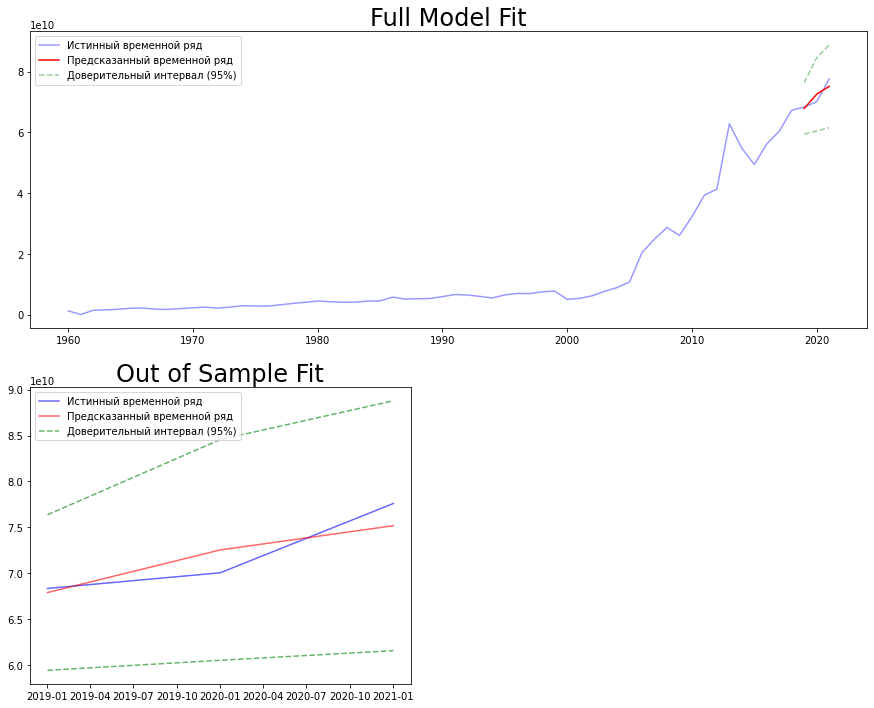

In [19]:
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP"], color="blue", label="Истинный временной ряд", alpha=0.4)

plt.plot(
    pred_df.loc[test_data.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Предсказанный временной ряд",
)

plt.plot(
    pred_df.loc[test_data.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Доверительный интервал (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_data.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_data.index]["GDP"], color="blue", label="Истинный временной ряд", alpha=0.6
)

plt.plot(
    pred_df.loc[test_data.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Предсказанный временной ряд",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_data.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Доверительный интервал (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_data.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

## 6
Выводы.
На полученных графиках наглядно видно, что наши предсказания для последних трех лет (2019-2021) очень близко подходят к истинными значениям ВВП Ганы и попадают в доверительный интервал в 95%. Правильно была определена статичность ряда, выбрана модель (ARIMA) и подобраны к ней параметры. Также очень удобно оказалось подорать параметры с помощью специального метода auto_arima() из pmdarima.

# Часть 2

## 1
Проверьте данные на наличие пропущенных дат.

In [20]:
data

,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


asfreq() - этот метод нужен для периодизации данных (установления жёстких периодов в качестве индексов), когда мы рассматриваем какую нибудь величину которая меняется с заданной частотой (от раз в наносекунду, до раза в год) этот метод проверит все ли периоды заполнены данными, если скажем пропущена какая-то секунда (час, день месяц) он на место этой пропущенной даты поставит NaN а мы этот пропуск сможем найти isna() и что-нибудь с ним сделать.

In [21]:
data = data.asfreq(freq='AS')# d m

После применения метода asfreq(freq='d') появилось много строк со значениями NaN. asfreq() - это преобразование временного ряда к новой частоте. Если указать новую частоту freq='d' (d - дни), то появляется 22282 строки.
У нас, по заданию freq='AS', количество строк не поменялось.

## 2
Проверьте данные на наличие пропущенных значений

In [22]:
data.isna().sum()

GDP    0
dtype: int64

У нас нет пропущенных значений.

## 3
Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на NaN.

In [23]:
data[data.GDP==0]

,GDP
year,
1961-01-01,0.0


In [24]:
data['GDP'] = data['GDP'].apply(lambda x: np.nan if x==0 else x)

In [25]:
data.isna().sum()

GDP    1
dtype: int64

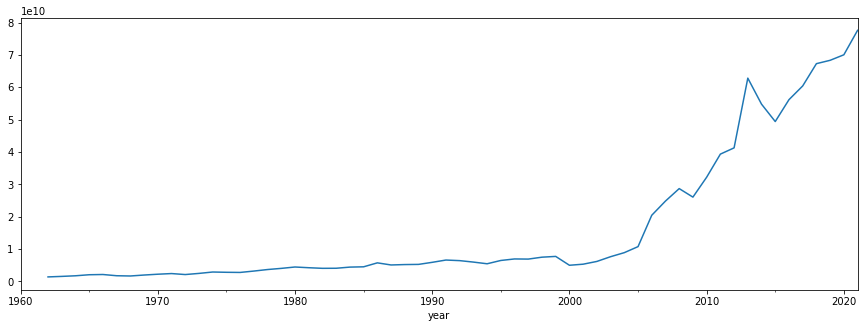

In [26]:
data.GDP.plot()
plt.show()

## 4
Для заполнения пропусков выполните интерполяцию с использованием метода .interpolate().

(62, 2)


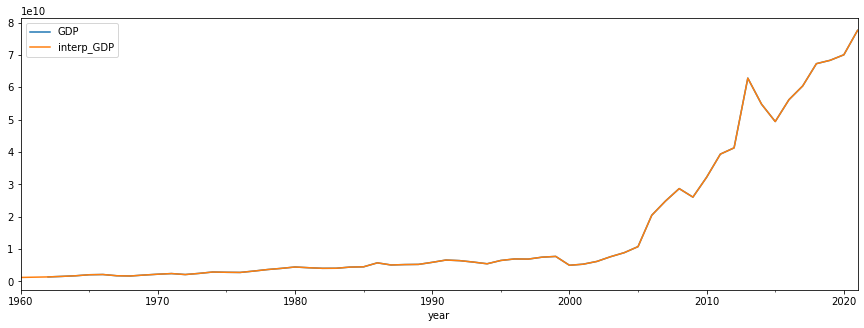

In [27]:
data['interp_GDP'] = data['GDP'].interpolate(method='linear')

print(data.shape)
data.plot()
#interpolated_data.plot()
plt.show()

In [28]:
data.isna().sum()

GDP           1
interp_GDP    0
dtype: int64

После интерполяции значение NaN в столбце GDP заменилось на числовое значение interp_GDP.

In [29]:
data

,GDP,interp_GDP
year,,
1960-01-01,1.217087e+09,1.217087e+09
1961-01-01,NaN,1.299720e+09
1962-01-01,1.382353e+09,1.382353e+09
1963-01-01,1.540616e+09,1.540616e+09
1964-01-01,1.731092e+09,1.731092e+09
...,...,...
2017-01-01,6.040638e+10,6.040638e+10
2018-01-01,6.729928e+10,6.729928e+10
2019-01-01,6.833754e+10,6.833754e+10


Значения, в которых были NaN заполнились значениями, при этом графики полностью сопадают.

## 5
Проверим полученный ряд на стационарность, определим параметры модели (ARIMA/ARMA) и запустим модель.

In [30]:
# разделим наши данные на тренировочную и тестовые выборки
train_data_interp = data.iloc[:-3]
test_data_interp = data.iloc[-3:]
train_data_interp.shape, test_data_interp.shape

((59, 2), (3, 2))

In [31]:
adfuller(train_data_interp.interp_GDP)

(0.8030073326980115,
 0.9916845572455877,
 10,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2194.307284305165)

На стационарность ряда интерполяция никак не повлияла. Он по-прежнему нестационарный. Подберем параметры d, p, q с помощью pmdarima.auto_arima() и построим с ними модель для нестационарного ряда ARIMA.

In [32]:
smodel = pm.auto_arima(
    train_data_interp.interp_GDP,#.dropna(), это нам уже не понадобится, т.к. у нас уже нет нулевых значений
    start_p=1,
    d=2,
    start_q=1,
    max_p=5,
    max_q=5,
    max_d=5,
    seasonal=False,
    trace=True
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.479, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.621, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.528, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.683, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.221, Time=0.10 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.822, Time=0.08 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.929, Time=0.15 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.861, Time=0.06 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.709, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.377, Time=0.07 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2692.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.257
Date:                Mon, 05 Feb 2024   AIC                           2680.513
Time:                        20:24:09   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.01e+55. Standard errors may be unstable.
"""

Лучшие параметры для наших интерполированных данных не изменились:
Best model:  ARIMA(p = 1, d = 2, q = 3)

In [33]:
# построим модель с параметрами p = 1, d = 2, q = 3
arima_model = ARIMA(train_data_interp["interp_GDP"], order=(1, 2, 3)) # ! порядок параметров order = (p, d, q)
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\toiri\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             interp_GDP   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.257
Date:                Mon, 05 Feb 2024   AIC                           2680.513
Time:                        20:24:29   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.01e+55. Standard errors may be unstable.
"""

AIC стал равен 2680.513

## 6
Вывод.
Модель немного, но улучшилась по сравнению с моделью, построенной на неинтерполированных данных. Об этом говорит метрика AIC = 2680.513 
(в первой части этого проекта был получен AIC = 2680.765).

Задание 8.3

1. Разбейте временной ряд на три набора (3 train + 3 test). Для этого воспользуйтесь классом TimeSeriesSplit из sklearn.model_selection с параметрами n_splits=3 и test_size=7 (или max_train_size=df.sales.count()-7). Наборы данных можно получить, вызвав метод split (временной ряд) у инициализированного TimeSeriesSplit.

Пример кода:

tscv = TimeSeriesSplit(...)
2. Выведите размеры полученных подвыборок:

train_test_groups = tscv.split(df.sales) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))
Обратите внимание на отличие в размерах выборок на рисунке с walk forward validation и множественным разбиением. В задании вы вывели размеры полученных выборок. Какой случай вы получили?

In [34]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3, test_size=7) # n_splits=3, max_train_size=data.GDP.count()-7

train_test_groups = tscv.split(data.GDP) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 41 TEST size: 7
TRAIN size: 48 TEST size: 7
TRAIN size: 55 TEST size: 7


Вы получили множественное разбиение, так как объём обучающих выборок различен, а в walk forward validation размер выборки train фиксирован.

# Часть 3

В скринкасте мы получаем предсказания с помощью model_results.forecast().

Любое обращение к методу forecast() возвращает объект ARCHModelForecast с тремя основными атрибутами:

.mean — условное среднее значение ряда;
.variance — условная дисперсия прогноза;
.residual_variance — прогнозируемая условная дисперсия остатков. Residual_variance будет отличаться от variance в случаях, когда значения ряда (не дисперсии, а именно сами значения) имеют зависимость от себя в прошлом. В скринкасте для предсказания дисперсии мы используем residual_variance, так как в нашем случае ряд стационарен и residual_variance и variance возвращают одинаковые значения.

## 1
Посчитайте волатильность для вашего временного ряда.

In [35]:
# data["spx_vol"] = (data.spx - data.spx.shift(1))/data.spx.shift(1)
# или 
data["GDP_vol"] = data.GDP.pct_change(1).mul(100).abs()
data

C:\Users\toiri\AppData\Local\Temp\ipykernel_16976\3033222942.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data["GDP_vol"] = data.GDP.pct_change(1).mul(100).abs()


,GDP,interp_GDP,GDP_vol
year,,,
1960-01-01,1.217087e+09,1.217087e+09,NaN
1961-01-01,NaN,1.299720e+09,0.000000
1962-01-01,1.382353e+09,1.382353e+09,13.578826
1963-01-01,1.540616e+09,1.540616e+09,11.448835
1964-01-01,1.731092e+09,1.731092e+09,12.363636
...,...,...,...
2017-01-01,6.040638e+10,6.040638e+10,7.551317
2018-01-01,6.729928e+10,6.729928e+10,11.410877
2019-01-01,6.833754e+10,6.833754e+10,1.542746


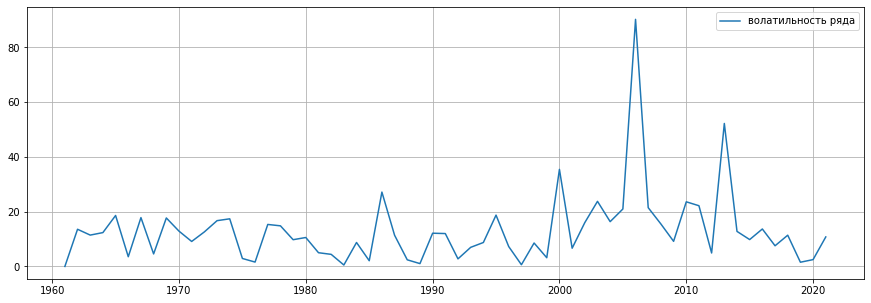

In [36]:
plt.plot(data.GDP_vol, label = 'волатильность ряда')
plt.legend()
plt.grid(True)
#data['GDP_vol'].plot()
plt.show();

## 2
Используйте GARCH-модель для предсказания волатильности.

In [38]:
# удалим первую строку с пропущенным значением
data = data.dropna()
data.shape

(60, 3)

In [39]:
# проверим ряд на стационарность
test = adfuller(data["GDP_vol"]) # Исходный ряд
print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])
if test[0] > test[4]["1%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -6.765043654720392
p-value:  2.730659059340401e-09
Critical values:  {'1%': -3.5463945337644063, '5%': -2.911939409384601, '10%': -2.5936515282964665}
ряд стационарен


c:\Users\toiri\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


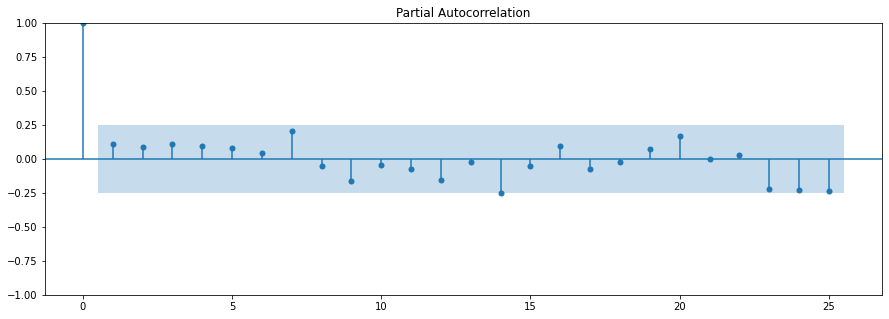

In [40]:
sgt.plot_pacf(data['GDP_vol'], lags=25)#, alpha=0.05)
plt.show();

Будем строить GARCH модель с параметрами p = 1 и q = 1, а также посмотрим параметры p = q = 7

In [43]:
#! pip install arch

In [41]:
# разделим данные на тренирововчную и тестовую выборки
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]
print(train_df.shape, test_df.shape)

# делаем что-то с данными как в скринкасте
garch_df = pd.DataFrame(data["GDP_vol"].loc[data.index])
garch_df.loc[train_df.index, "GDP_vol"] = train_df["GDP_vol"].dropna()

(57, 3) (3, 3)


In [42]:
# Моделируем ARCH
garch = arch_model(data["GDP_vol"].dropna(), p=7, q=7, vol='GARCH')

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = garch.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     92,   Neg. LLF: 212.44254769669917
Iteration:     10,   Func. Count:    179,   Neg. LLF: 211.24513338238728
Iteration:     15,   Func. Count:    264,   Neg. LLF: 211.08533841222376
Iteration:     20,   Func. Count:    349,   Neg. LLF: 210.66955624694918
Iteration:     25,   Func. Count:    434,   Neg. LLF: 210.58684039863914
Iteration:     30,   Func. Count:    519,   Neg. LLF: 210.60253665117077
Optimization terminated successfully    (Exit mode 0)
            Current function value: 210.58580445758776
            Iterations: 31
            Function evaluations: 522
            Gradient evaluations: 30


In [43]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                GDP_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -210.586
Distribution:                  Normal   AIC:                           453.172
Method:            Maximum Likelihood   BIC:                           485.860
                                        No. Observations:                   57
Date:                Mon, Feb 05 2024   Df Residuals:                       56
Time:                        20:26:36   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.9848      2.178      5.503  3.728e-08 [  7.716, 16.253]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         44.4501     80.564      0.552      0.581 [-1.135e+02,2.024e+02]
alpha[1]       0.0000      0.176      0.000      1.000      [ -0.346,  0.346]
alpha[2]       0.0000  3.659e-02      0.000      1.000 [-7.172e-02,7.172e-02]
alpha[3]   2.8903e-08      0.126  2.300e-07      1.000      [ -0.246,  0.246]
alpha[4]   3.4346e-03  3.044e-02      0.113      0.910 [-5.622e-02,6.309e-02]
alpha[5]   1.0786e-08  2.588e-02  4.167e-07      1.000 [-5.073e-02,5.073e-02]
alpha[6]       0.7408      1.529      0.485      0.628      [ -2.255,  3.737]
alpha[7]       0.1062      1.313  8.086e-02      0.936      [ -2.468,  2.680]
beta[1]        0.0000      1.008      0.000      1.000      [ -1.976,  1.976]
beta[2]        0.0000      0.134      0.000      1.000      [ -0.263,  0.263]
beta[3]        0.0000  5.028e-02      0.000      1.000 [-9.855e-02,9.855e-02]
beta[4]        0.0000      0.172      0.000      1.000      [ -0.336,  0.336]
beta[5]        0.0000  6.563e-02      0.000      1.000      [ -0.129,  0.129]
beta[6]        0.0000  4.260e-02      0.000      1.000 [-8.350e-02,8.350e-02]
beta[7]        0.0000      2.332      0.000      1.000      [ -4.570,  4.570]
=============================================================================

Covariance estimator: robust
"""

Для p = q = 1 AIC = 453.616
Для p = q = 7 AIC = 453.172

In [44]:
# предсказываем для тестовой выборки как в примере из скринкаста
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[test_df.index]

In [45]:
predictions_df

,GDP,interp_GDP,GDP_vol,Predictions
year,,,,
2019-01-01,6.833754e+10,6.833754e+10,1.542746,216.871683
2020-01-01,7.004320e+10,7.004320e+10,2.495937,48.079665
2021-01-01,7.759428e+10,7.759428e+10,10.780603,47.079594


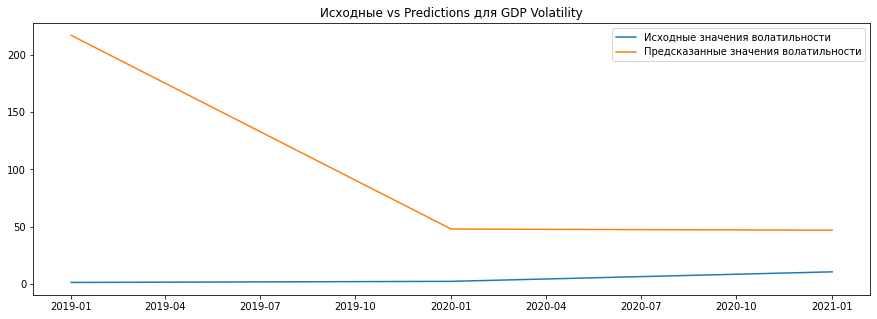

In [46]:
# отрисуем исходные значения и предсказанные
#fig, ax = plt.subplots()
plt.plot(predictions_df["GDP_vol"], label = 'Исходные значения волатильности')
plt.plot(predictions_df["Predictions"], label = 'Предсказанные значения волатильности')

plt.title("Исходные vs Predictions для GDP Volatility")
plt.legend()
plt.show();

## 3
Используйте линейную регрессию для получения прогноза.

In [47]:
# Разобьём сет на train test
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]
X_train = pd.DataFrame(range(data["GDP_vol"].shape[0]))[:train_df.shape[0]].fillna(0)
X_test = pd.DataFrame(range(data["GDP_vol"].shape[0]))[train_df.shape[0]:].fillna(0)
y_train = train_df["GDP_vol"].fillna(0)
y_test = test_df["GDP_vol"].fillna(0)

In [48]:
# Моделируем LR
lr = linear_model.LinearRegression().fit(X_train, y_train)
lr_pred_train = lr.predict(X_train)
lr_predict = lr.predict(X_test)

In [52]:
#garch_1 = arch_model(data["GDP_vol"], p=2, o=1, q=1, power=0.5, vol='GARCH').fit()
#garch_2 = arch_model(data["GDP_vol"], vol='APARCH').fit()

## 4
Визуализируйте полученное предсказание вместе с фактическим значением.

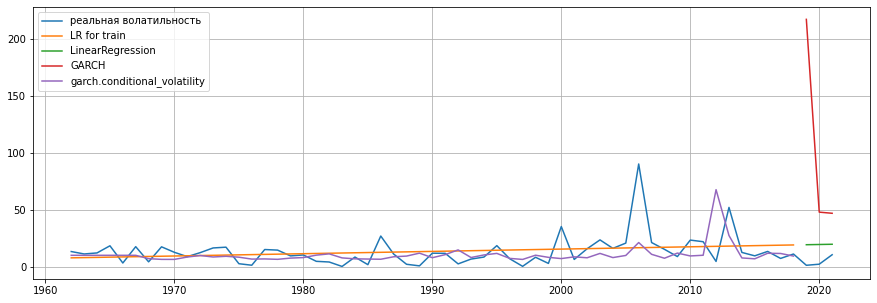

In [49]:
# Отрисуем результаты
fig, ax = plt.subplots()#figsize=(12, 10))
ax.plot(data['GDP_vol'], label='реальная волатильность')

ax.plot(pd.Series(lr_pred_train, index=y_train.index), label='LR for train')
ax.plot(pd.Series(lr_predict, index=y_test.index), label='LinearRegression')
ax.plot(predictions_df["Predictions"], label = 'GARCH')
ax.plot(model_results.conditional_volatility, label = 'garch.conditional_volatility')
#ax.plot(garch_1.conditional_volatility, label='GARCH')
#ax.plot(garch_2.conditional_volatility, label='APARCH')
ax.grid()
ax.legend();

Для построения модели GARCH у нас все-таки слишком мало данных. Модель GARCH не уловила дисперсию, так как такое поведение было для неё новым и подобные случаи отсутствовали в обучающей выборке. В примере из скринкаста был противоположный результат, так как имелось больше данных и в обучающей выборке были случаи и возрастания, и убывания дисперсии, что удалось уловить модели. 
Модель линейной регрессии отработала даже лучше, чем GARCH. Линейная регрессия в данном случае сведётся к главной компоненте данного ряда, очень близко к среднему значению ряда, но всё же не ему.

# Часть 4
Prophet 

In [59]:
#! pip install prophet

   ---------------------------------------- 13.3/13.3 MB 5.8 MB/s eta 0:00:00
   ---------------------------------------- 93.0/93.0 kB 1.3 MB/s eta 0:00:00
   ---------------------------------------- 913.1/913.1 kB 5.2 MB/s eta 0:00:00


In [60]:
import pandas as pd

from prophet import Prophet

url = 'https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv'

df = pd.read_csv(url)

df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [62]:
# Обучим модель на датасете:

model = Prophet()
model.fit(df)

00:02:15 - cmdstanpy - INFO - Chain [1] start processing
00:02:16 - cmdstanpy - INFO - Chain [1] done processing


Для получения прогноза необходимо использовать DataFrame со столбцом DS, содержащим даты, для которых должен быть сделан прогноз. Вы можете получить такой DataFrame, используя вспомогательный метод Prophet.make_future_dataframe(), в который необходимо передать число дней для совершения прогноза. По умолчанию он также будет включать более ранние даты, поэтому мы также увидим, как обучалась модель.

In [63]:
future_df = model.make_future_dataframe(periods=365)

future_df.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


В результате построения прогноза каждому DS будет присвоено прогнозируемое значение (YHAT). Также в прогнозном датафрейме будут два новых столбца ('yhat_lower', 'yhat_upper'), в которых будут находиться верхняя и нижняя границы доверительного интервала:

In [64]:
forecast_df = model.predict(future_df)
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.206964,7.482840,8.913128
3266,2017-01-16,8.531958,7.815111,9.278848
3267,2017-01-17,8.319376,7.562968,9.002860
3268,2017-01-18,8.151991,7.402663,8.911358
3269,2017-01-19,8.163908,7.415492,8.899912


Мы можем отобразить прогноз, вызвав метод Prophet.plot и передав ему полученный датафрейм с результатами прогноза:

c:\Users\toiri\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\toiri\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


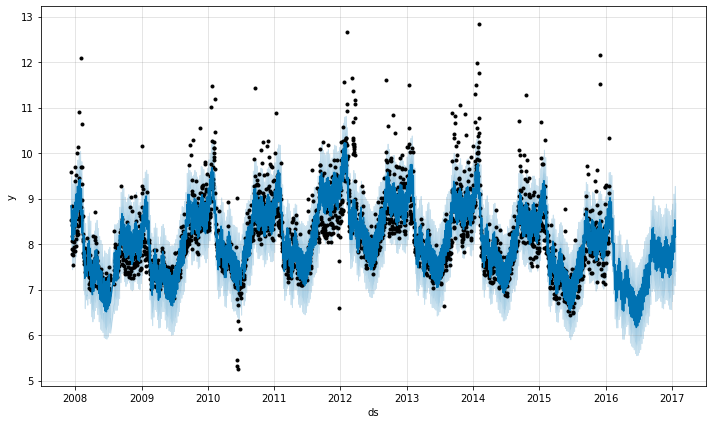

In [65]:
fig = model.plot(forecast_df)

Чтобы увидеть компоненты ряда, можно использовать метод Prophet.plot_components. По умолчанию предоставляются тренд и годовая и недельная сезонность временного ряда.

c:\Users\toiri\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\toiri\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\toiri\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series contain

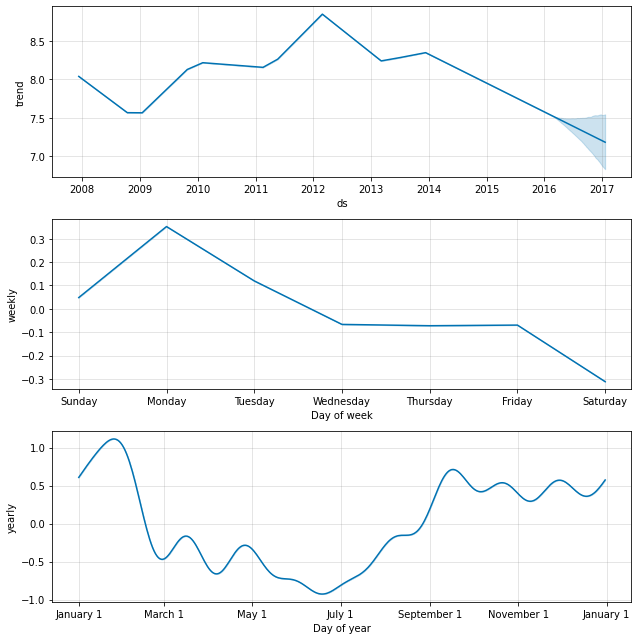

In [66]:
fig = model.plot_components(forecast_df)

In [50]:
import pandas as pd

from prophet import Prophet

In [51]:
# переименнуем столбцы в DS и Y для Prophet

data_prophet = pd.read_csv('ghana_gdp.csv')
data_prophet.rename(columns={'year': 'ds', 'GDP (current US$)': 'y'}, inplace=True)
data_prophet.head()

,ds,y
0,1960-01-01,1.217087e+09
1,1961-01-01,0.000000e+00
2,1962-01-01,1.382353e+09
3,1963-01-01,1.540616e+09
4,1964-01-01,1.731092e+09


In [52]:
# создание модели
model = Prophet()

# обучение модели
model.fit(data_prophet)

20:29:10 - cmdstanpy - INFO - Chain [1] start processing
20:29:11 - cmdstanpy - INFO - Chain [1] done processing


In [53]:
# Прогнозирование (у нас в датафрейме года. прогноз делается по дням, значит в periods надо 
# записать 365 дней, тогда прогноз будет на один год вперед)
future = model.make_future_dataframe(periods=365)

# Прогноз
forecast_dfp = model.predict(future)

In [57]:
forecast_dfp[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
422,2021-12-28,5.415319e+10,5.075593e+10,5.759687e+10
423,2021-12-29,6.408739e+10,6.045328e+10,6.766890e+10
424,2021-12-30,7.164489e+10,6.801059e+10,7.496345e+10
425,2021-12-31,7.661805e+10,7.305793e+10,8.011914e+10
426,2022-01-01,7.887149e+10,7.530308e+10,8.234201e+10


c:\Users\toiri\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\toiri\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


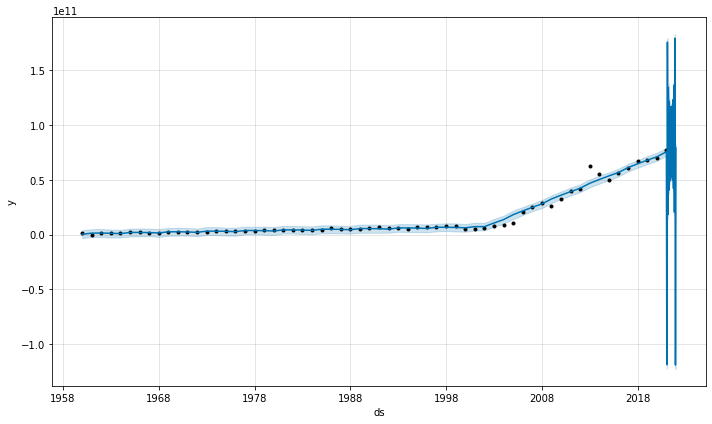

In [58]:
# отобразим прогноз
fig = model.plot(forecast_dfp)

c:\Users\toiri\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\toiri\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\toiri\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series contain

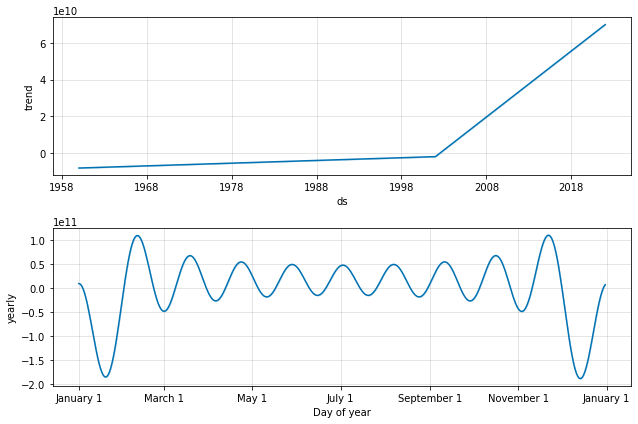

In [60]:
# посмотрим компоненты 
fig = model.plot_components(forecast_dfp)